## Fetch Data from API (SerpAPI)

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import numpy as np

from dotenv import load_dotenv
import requests
import os

In [2]:
# Tokens for each topic
tokens = {
    'technology': "CAAqJggKIiBDQkFTRWdvSUwyMHZNRGRqTVhZU0FtVnVHZ0pWVXlnQVAB",
    'sports': 'CAAqJggKIiBDQkFTRWdvSUwyMHZNRFp1ZEdvU0FtVnVHZ0pWVXlnQVAB',
    'entertainment': 'CAAqJggKIiBDQkFTRWdvSUwyMHZNREpxYW5RU0FtVnVHZ0pWVXlnQVAB',
}

In [3]:
# Function to fetch data / JSON from API
def fetch_data(topic_token, section_token=None):
    url = "https://serpapi.com/search"

    params = {
    'engine': 'google_news',
    'hl': 'en',
    'topic_token': topic_token,
    'api_key': os.environ.get("API_KEY")
    }

    if section_token:
        params['section_token'] = section_token

    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
        else:
            data = {}
            response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
    except requests.exceptions.RequestException as e:
        print(f"Other error occurred: {e}")

    return data

In [4]:
# Function to extract data from JSON to Python list
def extract_data(topic_token, topic):
    titles = []
    section_tokens = [i['section_token'] for i in fetch_data(topic_token)['sub_menu_links']]

    for section_token in section_tokens:
        data = fetch_data(topic_token, section_token)['news_results']
        for item in data:
            title = (item.get('title', item.get('highlight', {}).get('title', None)), topic)
            stories = item.get('stories', [])
            titles.extend([title] + [(story.get('title', None), topic) for story in stories])

    return titles

In [5]:
# Extract data for all the topics defined
data = []
for i in tokens.keys():
    data += extract_data(tokens[i], i.title())

In [6]:
# Convert data (Python list to dataframe)
df = pd.DataFrame(data, columns=['news', 'topic'])
df.head()

,news,topic
0,"iPhone 17 rumors: A19 chip details, smaller Dy...",Technology
1,'iPhone 17 Air' Rumored to Surpass iPhone 6 as...,Technology
2,"Apple iPhone 17 Air rumors: Specs, price, rele...",Technology
3,iPhone 17 Design Upgrade Will Make It Thinnest...,Technology
4,Google Pixel and other Android phones add 'Scr...,Technology


In [7]:
# Load dataframe to excel
df.to_excel('news.xlsx', index=False)

## News Topic Modeling

### Load Data

In [3]:
df = pd.read_excel('news.xlsx')
df.head()

,news,topic
0,"iPhone 17 rumors: A19 chip details, smaller Dy...",Technology
1,'iPhone 17 Air' Rumored to Surpass iPhone 6 as...,Technology
2,"Apple iPhone 17 Air rumors: Specs, price, rele...",Technology
3,iPhone 17 Design Upgrade Will Make It Thinnest...,Technology
4,Google Pixel and other Android phones add 'Scr...,Technology


In [19]:
def merge_text(df, column, category):
    text = ' '.join(df[df[column] == category]['news'])
    return text

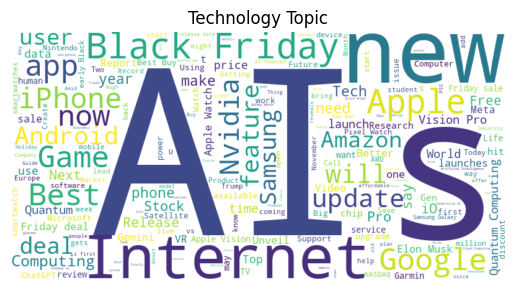

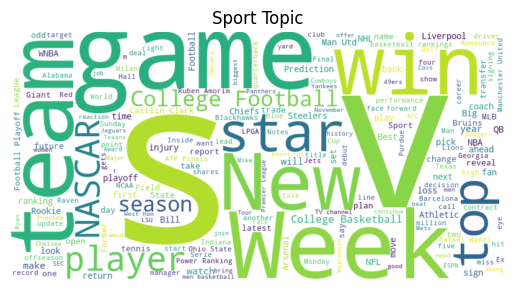

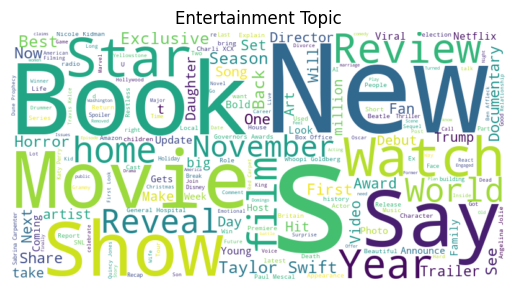

In [ ]:
# Show wordcloud for texts in each topic
tech = merge_text(df, 'topic', 'Technology')
sport = merge_text(df, 'topic', 'Sports')
entertainment = merge_text(df, 'topic', 'Entertainment')
wordcloud_tech = WordCloud(width=800, height=400, background_color='white').generate(tech)
wordcloud_sport = WordCloud(width=800, height=400, background_color='white').generate(sport)
wordcloud_entertainment = WordCloud(width=800, height=400, background_color='white').generate(entertainment)
plt.imshow(wordcloud_tech, interpolation='bilinear')
plt.title('Technology Topic')
plt.axis('off')
plt.show()
plt.imshow(wordcloud_sport, interpolation='bilinear')
plt.title('Sport Topic')
plt.axis('off')
plt.show()
plt.imshow(wordcloud_entertainment, interpolation='bilinear')
plt.title('Entertainment Topic')
plt.axis('off')
plt.show()

### Exploratory Data Analysis and Data Preprocessing

In [4]:
# Show the amount of data for each topic
df['topic'].value_counts()

topic
Sports           1598
Entertainment    1132
Technology       1034
Name: count, dtype: int64

In [5]:
# Chech duplicate news
df['news'].value_counts()

news
Big 12 football on TNT? New deal will feature 13 football games on WBD channels after settlement    4
There Is One Major Glitch With WBD-ESPN Deal to License ‘Inside the NBA’                            4
'Inside the NBA' moving to ESPN, ABC next season                                                    4
Large piece of metal falls from AT&T Stadium roof prior to Texans-Cowboys game                      4
Cowboys' embarrassing start includes little effort on Texans' TD and a failed fake punt             4
                                                                                                   ..
Mike Tomlin Running 'Circles' Around John Harbaugh In Steelers-Ravens Rivalry, Says Kyle Brandt     1
The Truth About Netflix and Sports Isn’t Good for Sports Fans                                       1
2025 NFL Draft quarterback stock report: Which QBs should be on the Giants’ radar?                  1
What's next for the Giants, Daniel Jones after QB switch                     

In [6]:
# Remove duplicate news
df['news'] = df['news'].drop_duplicates()

In [7]:
# Check duplicate news
df['news'].value_counts(ascending=False)

news
iPhone 17 rumors: A19 chip details, smaller Dynamic Island, more                                                  1
Amanda Balionis shares glimpse into 'paradise' after honest Rory McIlroy admission                                1
Rory McIlroy's LIV Golf dream edges closer to becoming reality after public appearance                            1
Trump spotted sitting with head of Saudi Arabia’s Public Investment Fund at UFC fight                             1
Trump steps into the PGA-LIV drama: I can fix this in ’15 minutes’                                                1
                                                                                                                 ..
Beyoncé Fans & Lizzo Are ‘Not Ready’ for NFL Christmas Halftime Set: ‘This Is Revolutionary’                      1
Chargers 34-27 Bengals (Nov 17, 2024) Game Recap                                                                  1
Matt Eberflus: We’ll send tape of FG block to league, Packers were 

In [8]:
# Remove missing values
df.dropna(how='any', inplace=True)

In [9]:
# encoder = LabelEncoder()
# encoder.fit(['Technology', 'Sports', 'Entertainment'])
# df['encoded_topic'] = encoder.transform(df['topic'])
# df.head()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3485 entries, 0 to 3763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    3485 non-null   object
 1   topic   3485 non-null   object
dtypes: object(2)
memory usage: 81.7+ KB


In [11]:
df.describe()

,news,topic
count,3485,3485
unique,3485,3
top,"iPhone 17 rumors: A19 chip details, smaller Dy...",Sports
freq,1,1492


In [12]:
vectorizer = TfidfVectorizer(max_df=.95, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(df['news'])

### Latent Dirichlet Allocation (LDA)

In [13]:
# Create / train Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [14]:
# Show the most relevant words for each topic
for index, topic in enumerate(lda.components_):
    print(f"TOP 20 WORDS FOR TOPIC {index}")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-20:]])

TOP 20 WORDS FOR TOPIC 0
['10', 'android', 'new', 'says', 'apple', 'rankings', '11', 'college', 'google', 'november', '25', 'friday', 'vs', '18', 'watch', 'black', 'basketball', 'best', '2024', 'ai']
TOP 20 WORDS FOR TOPIC 1
['gets', 'apple', 'home', 'release', 'report', 'man', 'injury', 'nvidia', 'big', 'pro', 'internet', 'week', 'time', 'game', 'quantum', 'college', 'ai', 'computing', 'new', 'football']
TOP 20 WORDS FOR TOPIC 2
['movie', 'team', 'paul', 'nfl', 'day', 'tour', 'fans', 'cup', 'nba', 'wnba', 'nascar', 'review', 'video', '2024', '2025', 'year', 'season', 'win', 'book', 'new']


In [15]:
# Create new column in the dataframe (df)
topic_lda = lda.transform(dtm)
df['topic_lda'] = topic_lda.argmax(axis=1)
df.head()

,news,topic,topic_lda
0,"iPhone 17 rumors: A19 chip details, smaller Dy...",Technology,1
1,'iPhone 17 Air' Rumored to Surpass iPhone 6 as...,Technology,0
2,"Apple iPhone 17 Air rumors: Specs, price, rele...",Technology,1
3,iPhone 17 Design Upgrade Will Make It Thinnest...,Technology,0
4,Google Pixel and other Android phones add 'Scr...,Technology,0


In [16]:
df.pivot_table(index=df['topic'], columns=df['topic_lda'], aggfunc='count')

news          
topic_lda        0    1    2
topic                       
Entertainment  317  251  438
Sports         520  435  537
Technology     484  364  139

In [17]:
# Encode topic based on the most occurred topic_nmf for each category
encoded_topic_lda_mapper = dict()
unique_topic_lda = df.topic_lda.unique()
for i in range(len(unique_topic_lda)):
    if encoded_topic_lda_mapper.get(unique_topic_lda[i-1], None) in encoded_topic_lda_mapper.values():
        encoded_topic_lda_mapper[unique_topic_lda[i]] = df[df['topic_lda'] == unique_topic_lda[i]]['topic'].value_counts(ascending=False).index[1]
    else:
        encoded_topic_lda_mapper[unique_topic_lda[i]] = df[df['topic_lda'] == unique_topic_lda[i]]['topic'].value_counts(ascending=False).index[0]


encoded_topic_lda_mapper = {value: key for key, value in encoded_topic_lda_mapper.items()}

encoded_topic_lda = df['topic'].apply(lambda x: encoded_topic_lda_mapper[x])

In [25]:
print(confusion_matrix(encoded_topic_lda, df['topic_lda']))
print(classification_report(encoded_topic_lda, df['topic_lda']))

[[484 364 139]
 [520 435 537]
 [317 251 438]]
              precision    recall  f1-score   support

           0       0.37      0.49      0.42       987
           1       0.41      0.29      0.34      1492
           2       0.39      0.44      0.41      1006

    accuracy                           0.39      3485
   macro avg       0.39      0.41      0.39      3485
weighted avg       0.39      0.39      0.38      3485



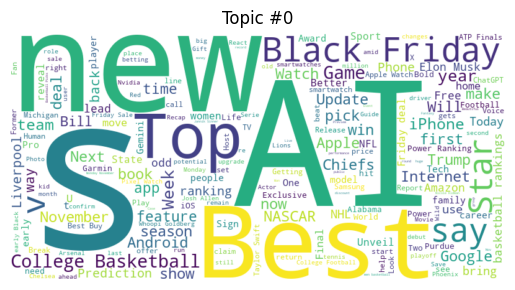

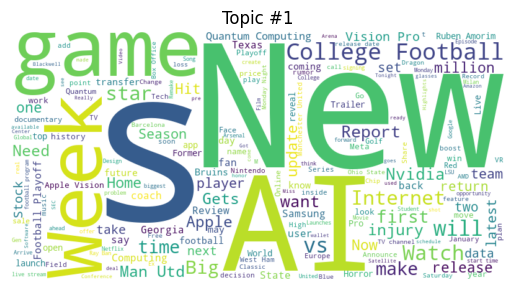

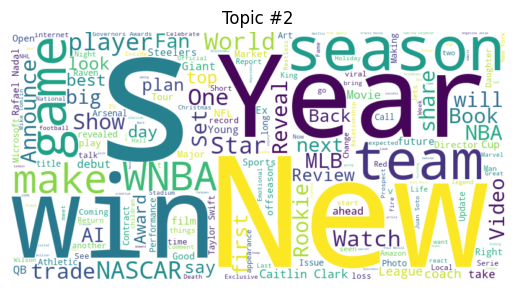

In [ ]:
# Show wordcloud for texts in each topic generated by Latent Dirichlet Allocation (LDA)
first_topic = merge_text(df, 'topic_lda', 0)
second_topic = merge_text(df, 'topic_lda', 1)
third_topic = merge_text(df, 'topic_lda', 2)
wordcloud_first = WordCloud(width=800, height=400, background_color='white').generate(first_topic)
wordcloud_second = WordCloud(width=800, height=400, background_color='white').generate(second_topic)
wordcloud_third = WordCloud(width=800, height=400, background_color='white').generate(third_topic)
plt.imshow(wordcloud_first, interpolation='bilinear')
plt.title('Topic #0')
plt.axis('off')
plt.show()
plt.imshow(wordcloud_second, interpolation='bilinear')
plt.title('Topic #1')
plt.axis('off')
plt.show()
plt.imshow(wordcloud_third, interpolation='bilinear')
plt.title('Topic #2')
plt.axis('off')
plt.show()

### Non-negative Matrix Factorization

In [31]:
nmf = NMF(n_components=3, random_state=42)
nmf.fit(dtm)

NMF(n_components=3, random_state=42)

In [32]:
# Show the most relevant words for each topic
for index, topic in enumerate(nmf.components_):
    print(f"TOP 20 WORDS FOR TOPIC {index}")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-20:]])

TOP 20 WORDS FOR TOPIC 0
['men', 'watch', 'season', 'playoff', 'state', '12', '11', 'picks', 'game', 'november', '25', 'rankings', '18', 'vs', 'best', 'week', 'basketball', 'football', '2024', 'college']
TOP 20 WORDS FOR TOPIC 1
['use', 'revolution', 'research', 'market', 'elon', 'future', 'gemini', 'generative', 'voice', 'stock', 'says', 'powered', 'musk', 'trump', 'tech', 'google', 'quantum', 'computing', 'nvidia', 'ai']
TOP 20 WORDS FOR TOPIC 2
['google', 'price', 'gets', 'sale', 'samsung', 'man', 'iphone', 'trailer', 'internet', 'year', 'star', 'pro', '2025', 'book', 'release', 'friday', 'black', 'watch', 'apple', 'new']


In [33]:
# Create new column in the dataframe (df)
topic_nmf = nmf.transform(dtm)
df['topic_nmf'] = topic_nmf.argmax(axis=1)
df.head()

,news,topic,topic_lda,topic_nmf
0,"iPhone 17 rumors: A19 chip details, smaller Dy...",Technology,1,2
1,'iPhone 17 Air' Rumored to Surpass iPhone 6 as...,Technology,0,2
2,"Apple iPhone 17 Air rumors: Specs, price, rele...",Technology,1,2
3,iPhone 17 Design Upgrade Will Make It Thinnest...,Technology,0,2
4,Google Pixel and other Android phones add 'Scr...,Technology,0,2


In [34]:
df.pivot_table(index=df['topic'], columns=df['topic_nmf'], aggfunc='count')

news           topic_lda          
topic_nmf        0    1    2         0    1    2
topic                                           
Entertainment  224   80  702       224   80  702
Sports         751   44  697       751   44  697
Technology      88  315  584        88  315  584

In [35]:
# Encode topic based on the most occurred topic_nmf for each category
encoded_topic_nmf_mapper = dict()
for i in df.topic_nmf.unique():
    encoded_topic_nmf_mapper[i] = df[df['topic_nmf'] == i]['topic'].value_counts(ascending=False).index[0]

encoded_topic_nmf_mapper = {value: key for key, value in encoded_topic_nmf_mapper.items()}

encoded_topic_nmf = df['topic'].apply(lambda x: encoded_topic_nmf_mapper[x])

In [36]:
print(confusion_matrix(encoded_topic_nmf, df['topic_nmf']))
print(classification_report(encoded_topic_nmf, df['topic_nmf']))

[[751  44 697]
 [ 88 315 584]
 [224  80 702]]
              precision    recall  f1-score   support

           0       0.71      0.50      0.59      1492
           1       0.72      0.32      0.44       987
           2       0.35      0.70      0.47      1006

    accuracy                           0.51      3485
   macro avg       0.59      0.51      0.50      3485
weighted avg       0.61      0.51      0.51      3485



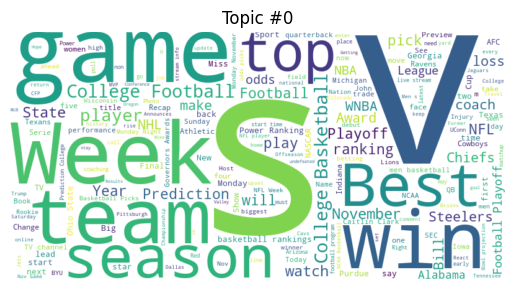

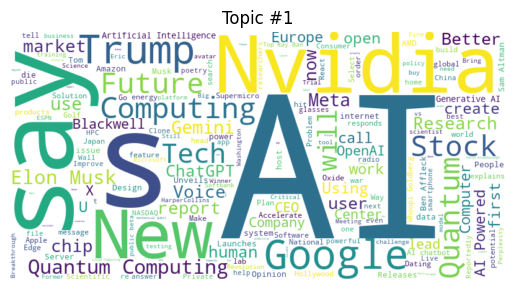

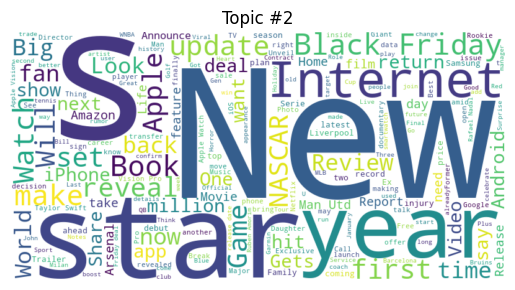

In [ ]:
# Show wordcloud for texts in each topic generated by Non-negative Matrix Factorization (NMF)
first_topic = merge_text(df, 'topic_nmf', 0)
second_topic = merge_text(df, 'topic_nmf', 1)
third_topic = merge_text(df, 'topic_nmf', 2)
wordcloud_first = WordCloud(width=800, height=400, background_color='white').generate(first_topic)
wordcloud_second = WordCloud(width=800, height=400, background_color='white').generate(second_topic)
wordcloud_third = WordCloud(width=800, height=400, background_color='white').generate(third_topic)
plt.imshow(wordcloud_first, interpolation='bilinear')
plt.title('Topic #0')
plt.axis('off')
plt.show()
plt.imshow(wordcloud_second, interpolation='bilinear')
plt.title('Topic #1')
plt.axis('off')
plt.show()
plt.imshow(wordcloud_third, interpolation='bilinear')
plt.title('Topic #2')
plt.axis('off')
plt.show()